In [1]:
import numpy as np
from numpy import matlib as ml
import pandas as pd
import os
import warnings
import librosa
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from random import shuffle
import scipy.stats as st

from pynwb import NWBHDF5IO
from pynwb.image import ImageSeries
from pynwb.epoch import TimeIntervals

from sklearn.decomposition import PCA
import pdb

import warnings
warnings.filterwarnings('ignore')

In [3]:
# ----- SET UP FILE HANDLING -----

computer = 'Ernest'
# computer = 'Dorian'

match computer:
    case 'Dorian':
        nwbpath = 'M:\\scn2a-paper-GWJSNH\\NWB-files'
        
    case 'Ernest':
        nwbpath = 'C:\\Users\\nhogl\\Documents\\GitHub\\scn2a-paper-GWJSNH-code\\NWB'

allnwb = []
allnwb += [os.path.join(nwbpath,each) for each in os.listdir(nwbpath)]

figp=os.path.join('figures','2024July') # where to save figures
saveplots=False

In [35]:
# ----- DEFINE FUNCTIONS -----

# -- collect all annotations for a behavior into one table across all animals --
def consolidate_single_behavior_table(assay,behavior,nwbpath,printy):
    ''''''
    
    # collate all instances of behavior into a table
    # plot per individual cdf of time to behavior
    # normalize to total time doing that behavior
    # calculate as percent of assay time

    # make functions to generate table per assay x behavior

    FHet = 0
    MHet = 0
    FWT = 0
    MWT = 0
    
    allnwb = []
    allnwb += [os.path.join(nwbpath,each) for each in os.listdir(nwbpath) if assay in each]
    
    for i,fname in enumerate(allnwb):
                
        # open file
        io = NWBHDF5IO(os.path.join(nwbpath,fname), mode="r") # <-- open in write to append snippets?
        nwbfile = io.read()

        # for sanity check, print out the name of the file being handled
        pathsplit = fname.split('\\')
        recstem = pathsplit[-1].strip('.nwb')
        if printy:
            print(recstem)
            
        try:
            
            data = nwbfile.intervals[f'single_behavior_{behavior}'].to_dataframe()
            nrentries = data.shape[0]

            # add metadata
            pair_tag = fname.split('\\')[-1].split('_')[1] # label the pair the observation came from    
            massGT = [nwbfile.subject.genotype]*nrentries
            massPairtag = [pair_tag]*nrentries
            massSex = [nwbfile.subject.sex]*nrentries
            massColors = [nwbfile.lab_meta_data['vole_metadata'].colors[:]]*nrentries
            if np.logical_and(nwbfile.subject.genotype == 'Het', nwbfile.subject.sex=='F'): 
                massWithinGroup = [FHet]*nrentries
                FHet+=1
            elif np.logical_and(nwbfile.subject.genotype == 'WT', nwbfile.subject.sex=='F'): 
                massWithinGroup = [FWT]*nrentries
                FWT+=1
            elif np.logical_and(nwbfile.subject.genotype == 'Het', nwbfile.subject.sex=='M'):
                massWithinGroup = [MHet]*nrentries
                MHet+=1
            elif np.logical_and(nwbfile.subject.genotype == 'WT', nwbfile.subject.sex=='M'):
                massWithinGroup = [MWT]*nrentries
                MWT+=1

            # add columns
            data['pair_tag'] = massPairtag
            data['sex'] = massSex
            data['GT'] = massGT
            data['pair'] = massWithinGroup
            data['color'] = massColors

            # consolidate into one big dataframe
            if i==0:
                rundf = data
            else:
                rundf = pd.concat([rundf,data])
            
        except:
            print(f'No {behavior}')
            
    rundf['raw_cumes'] = rundf.groupby('pair_tag').duration.cumsum()
    rundf['cumes_assay_frac'] = rundf.raw_cumes/1800
    rundf['totals'] = rundf.groupby('pair_tag')['duration'].transform('sum')
    rundf['cumes_behav_frac'] = rundf.raw_cumes/rundf.totals
            
    return rundf

# -- Convert rounded timestamps into 0.1s binary bins --
def make_bins_from_DF(df,assaylen):

    allpairs = np.unique(df.pair_tag)
    
    stepsize = 0.1
    nrsteps = int((assaylen)/stepsize)
    bins = np.linspace(0, 1800-stepsize, num=nrsteps)
    nrbins = len(bins)

    for j,pair in enumerate(allpairs):
        thisdf = df[df.pair_tag==pair]
        gt = np.unique(thisdf.GT)[0]
        sex = np.unique(thisdf.sex)[0]
        pn = np.unique(thisdf.pair)[0]
        thisdf['starts_idx'] = np.round(thisdf.start_time,decimals=1)*10
        thisdf['ends_idx'] = np.round(thisdf.stop_time,decimals=1)*10
        startsl = thisdf.starts_idx.to_list()
        endsl = thisdf.ends_idx.to_list()
        blankbins = np.zeros((len(bins,)))
        for i,start in enumerate(startsl):
            blankbins[int(start):int(endsl[i])] = 1
        GTs = [gt]*nrsteps
        sexes = [sex]*nrsteps
        PTs = [pair]*nrsteps
        pairnr = [pn]*nrsteps
        bindat = {'bins': bins, 'data': blankbins, 'sex':sexes,'GT':GTs,'pair_tag':PTs,'pair':pairnr}
        bindf = pd.DataFrame(data=bindat) 

        if j==0:
            collbins = bindf
        else:
            collbins = pd.concat([collbins,bindf])

    collbins['raw_cumes'] = collbins.groupby('pair_tag').data.cumsum()/10
    collbins['totals'] = collbins.groupby('pair_tag')['data'].transform('sum')/10
    collbins['cumes_behav_frac'] = collbins.raw_cumes/collbins.totals
        
    return collbins

# -- Plotting for binned data --
def make_cumulative_binned_plots(rundf,sex,behavior,assay):
    ''''''
    nrows=1
    ncols=2

    if sex=='M':
        usepal = mpal
    else:
        usepal = fpal

    # make figure and subplots
    f, ax = plt.subplots(nrows,ncols,figsize=(6, 3))
    f.tight_layout()

    ax0 = sns.lineplot(
        data=rundf[rundf.sex==sex],
        x="bins", y="raw_cumes", hue="GT", units="pair_tag",
        estimator=None, lw=1,palette=usepal,hue_order=ho,
        ax=ax[0],
    )
    ax0.set_xlabel('assay time (s)')
    ax0.set_ylabel('total time (s)')


    ax1 = sns.lineplot(
        data=rundf[rundf.sex==sex],
        x="bins", y="cumes_behav_frac", hue="GT", units="pair_tag",
        estimator=None, lw=1,palette=usepal,hue_order=ho,
        ax=ax[1],
    )
    ax1.set_xlabel('assay time (s)')
    ax1.set_ylabel(f'fraction {behavior} time')

    f.suptitle(f'Cumulative {behavior} in {assay}', y=1.02)
    
def make_cumulative_binned_plots_mean(rundf,sex,behavior,assay):
    ''''''
    nrows=1
    ncols=2

    if sex=='M':
        usepal = mpal
    else:
        usepal = fpal

    # make figure and subplots
    f, ax = plt.subplots(nrows,ncols,figsize=(6, 3))
    f.tight_layout()

    ax0 = sns.lineplot(
        data=rundf[rundf.sex==sex],
        x="bins", y="raw_cumes", hue="GT",
        lw=1,palette=usepal,hue_order=ho,
        ax=ax[0],
    )
    ax0.set_xlabel('assay time (s)')
    ax0.set_ylabel('total time (s)')


    ax1 = sns.lineplot(
        data=rundf[rundf.sex==sex],
        x="bins", y="cumes_behav_frac", hue="GT", 
        lw=1,palette=usepal,hue_order=ho,
        ax=ax[1],
    )
    ax1.set_xlabel('assay time (s)')
    ax1.set_ylabel(f'fraction {behavior} time')

    f.suptitle(f'Cumulative {behavior} in {assay}', y=1.02)
    
# -- Plotting for unbinned data --
def make_cumulative_time_plots(rundf,sex,behavior,assay):
    ''''''
    nrows=1
    ncols=2

    if sex=='M':
        usepal = mpal
    else:
        usepal = fpal

    # make figure and subplots
    f, ax = plt.subplots(nrows,ncols,figsize=(6, 3))
    f.tight_layout()

    ax0 = sns.lineplot(
        data=rundf[rundf.sex==sex],
        x="start_time", y="raw_cumes", hue="GT", units="pair_tag",
        estimator=None, lw=1,palette=usepal,hue_order=ho,
        ax=ax[0],
    )
    ax0.set_xlabel('assay time (s)')
    ax0.set_ylabel('total time (s)')


    ax1 = sns.lineplot(
        data=rundf[rundf.sex==sex],
        x="start_time", y="cumes_behav_frac", hue="GT", units="pair_tag",
        estimator=None, lw=1,palette=usepal,hue_order=ho,
        ax=ax[1],
    )
    ax1.set_xlabel('assay time (s)')
    ax1.set_ylabel(f'fraction {behavior} time')

    f.suptitle(f'Cumulative {behavior} in {assay}', y=1.02)
    
# -- Top level control function --
def single_behavior_binned_collate_data_and_plot(assay,assaylen,behavior,nwbpath,printy):
    rawdf = consolidate_single_behavior_table(assay,behavior,nwbpath,printy)
    bindf = make_bins_from_DF(rawdf,assaylen)
    make_cumulative_binned_plots(bindf,'M',behavior,assay)
    make_cumulative_binned_plots(bindf,'F',behavior,assay)
    return rawdf,bindf

def single_behavior_binned_collate_data_and_plot_mean(assay,assaylen,behavior,nwbpath,printy):
    rawdf = consolidate_single_behavior_table(assay,behavior,nwbpath,printy)
    bindf = make_bins_from_DF(rawdf,assaylen)
    make_cumulative_binned_plots_mean(bindf,'M',behavior,assay)
    make_cumulative_binned_plots_mean(bindf,'F',behavior,assay)
    return rawdf,bindf

# -- Recombine concatenated tables from multiple behaviors --
def combine_concatenated_behavior_tables(concattab):
    concattab.pop('raw_cumes')
    concattab.pop('cumes_assay_frac')
    concattab.pop('totals')
    concattab.pop('cumes_behav_frac')
    concattab.pop('atype')
    concattab = concattab.sort_values(by=['pair_tag','start_time'])
    concattab['raw_cumes'] = concattab.groupby('pair_tag').duration.cumsum()
    concattab['cumes_assay_frac'] = concattab.raw_cumes/1800
    concattab['totals'] = concattab.groupby('pair_tag')['duration'].transform('sum')
    concattab['cumes_behav_frac'] = concattab.raw_cumes/concattab.totals
    return concattab

# -- Top level combined control function --
def combined_behavior_bin_and_plot(catdf,assaylen,behavior,assay):
    catdfx = combine_concatenated_behavior_tables(catdf)
    catdfBins = make_bins_from_DF(catdfx,assaylen)
    make_cumulative_binned_plots(catdfBins,'M',behavior,assay)
    make_cumulative_binned_plots(catdfBins,'F',behavior,assay)
    return catdfBins

In [30]:
# -- collect all annotations for all behaviors and assays into one table across all animals --
def consolidate_table(nwbpath,printy):
    ''''''
    
    # collate all instances of behavior into a table
    # plot per individual cdf of time to behavior
    # normalize to total time doing that behavior
    # calculate as percent of assay time

    # make functions to generate table per assay x behavior

    FHet = 0
    MHet = 0
    FWT = 0
    MWT = 0
    
    allnwb = []
    allnwb += [os.path.join(nwbpath,each) for each in os.listdir(nwbpath)]
    
    for i,fname in enumerate(allnwb):
                
        # open file
        io = NWBHDF5IO(os.path.join(nwbpath,fname), mode="r") # <-- open in write to append snippets?
        nwbfile = io.read()

        # for sanity check, print out the name of the file being handled
        pathsplit = fname.split('\\')
        recstem = pathsplit[-1].strip('.nwb')
        if printy:
            print(recstem)
            
        try:
            
            df = nwbfile.intervals['annotated_behavior'].to_dataframe() # convert annotation table to dataframe
            data = df.copy()
            assaystart = data.start_time[data.behavior=='Start assay'].to_list()[0]
            data=data[data.behavior!='Start assay']
            data.start_time = data.start_time-assaystart
            data.stop_time = data.stop_time-assaystart
            nrentries = data.shape[0]
            
            if nwbfile.lab_meta_data['vole_metadata'].assay_type=='PPT':
                if nwbfile.lab_meta_data['vole_metadata'].assay_type__partner_chamber=='Left':
                    data.replace({'Left':'Partner'}, regex=True,inplace=True)
                    data.replace({'Right':'Stranger'}, regex=True,inplace=True)
                elif nwbfile.lab_meta_data['vole_metadata'].assay_type__partner_chamber=='Right':
                    data.replace({'Right':'Partner'}, regex=True,inplace=True)
                    data.replace({'Left':'Stranger'}, regex=True,inplace=True)
                else:
                    print('Invalid value for partner chamber.')

            # add metadata
            pair_tag = fname.split('\\')[-1].split('_')[1] # label the pair the observation came from    
            massGT = [nwbfile.subject.genotype]*nrentries
            massPairtag = [pair_tag]*nrentries
            massSex = [nwbfile.subject.sex]*nrentries
            massColors = [nwbfile.lab_meta_data['vole_metadata'].colors[:]]*nrentries
            massAssay = [nwbfile.lab_meta_data['vole_metadata'].assay_type]*nrentries

            # add columns
            data['pair_tag'] = massPairtag
            data['sex'] = massSex
            data['GT'] = massGT
            data['color'] = massColors
            data['assay'] = massAssay

            # consolidate into one big dataframe
            if i==0:
                rundf = data
            else:
                rundf = pd.concat([rundf,data])
            
        except:
            pdb.set_trace()
            
    return rundf


In [31]:
data = consolidate_table(nwbpath,True)

Nov22_Pair15_aggressio
Invalid value for partner chamber.
Nov22_Pair15_introductio
Invalid value for partner chamber.
Nov22_Pair15_PPT
Nov22_Pair15_reunio
Invalid value for partner chamber.
Nov22_Pair15_timedMating
Invalid value for partner chamber.
Nov22_Pair16_aggressio
Invalid value for partner chamber.
Nov22_Pair16_introductio
Invalid value for partner chamber.
Nov22_Pair16_PPT
Nov22_Pair16_reunio
Invalid value for partner chamber.
Nov22_Pair16_timedMating
Invalid value for partner chamber.
Nov22_Pair17_aggressio
Invalid value for partner chamber.
Nov22_Pair17_introductio
Invalid value for partner chamber.
Nov22_Pair17_PPT
Nov22_Pair17_reunio
Invalid value for partner chamber.
Nov22_Pair17_timedMating
Invalid value for partner chamber.
Nov22_Pair18_aggressio
Invalid value for partner chamber.
Nov22_Pair18_introductio
Invalid value for partner chamber.
Nov22_Pair18_PPT
Nov22_Pair18_reunio
Invalid value for partner chamber.
Nov22_Pair18_timedMating
Invalid value for partner chamber.


Nov22_Pair48_aggressio
Invalid value for partner chamber.
Nov22_Pair48_introductio
Invalid value for partner chamber.
Nov22_Pair48_PPT
Nov22_Pair48_reunio
Invalid value for partner chamber.
Nov22_Pair48_timedMating
Invalid value for partner chamber.
Nov22_Pair49_aggressio
Invalid value for partner chamber.
Nov22_Pair49_introductio
Invalid value for partner chamber.
Nov22_Pair49_PPT
Nov22_Pair49_reunio
Invalid value for partner chamber.
Nov22_Pair49_timedMating
Invalid value for partner chamber.
Nov22_Pair4_aggressio
Invalid value for partner chamber.
Nov22_Pair4_introductio
Invalid value for partner chamber.
Nov22_Pair4_PPT
Nov22_Pair4_reunio
Invalid value for partner chamber.
Nov22_Pair50_aggressio
Invalid value for partner chamber.
Nov22_Pair50_introductio
Invalid value for partner chamber.
Nov22_Pair50_PPT
Nov22_Pair50_reunio
Invalid value for partner chamber.
Nov22_Pair50_timedMating
Invalid value for partner chamber.
Nov22_Pair51_aggressio
Invalid value for partner chamber.
Nov22_

In [32]:
pptdat = data[data.assay=='PPT']
pptdat.head()

,start_time,stop_time,behavior,duration,atype,pair_tag,sex,GT,color,assay
id,,,,,,,,,,
1,0.001,6.000,Center,5.999,STATE,Pair15,F,Het,"[245.0, 201.0, 39.0]",PPT
2,6.001,13.000,Partner,6.999,STATE,Pair15,F,Het,"[245.0, 201.0, 39.0]",PPT
3,13.001,14.499,Interact Partner,1.498,STATE,Pair15,F,Het,"[245.0, 201.0, 39.0]",PPT
4,14.500,52.748,Huddle Partner,38.248,STATE,Pair15,F,Het,"[245.0, 201.0, 39.0]",PPT
5,52.749,54.498,Partner,1.750,STATE,Pair15,F,Het,"[245.0, 201.0, 39.0]",PPT


In [33]:
# write out big table
data.to_csv('all_annotations.csv')

In [36]:
# FIGURE OUT HOW TO DICE UP BIG TABLE
introsniffs = data[np.logical_and(data.behavior=='Sniff',data.assay=='Introduction')]
introsniffs_binned = make_bins_from_DF(introsniffs,1800) # make into 0.1 s bins
# rebin
# secbins = make_arbitrary_bins(1800,1)
# coll['binbins'] = pd.cut(coll.bins,secbins,labels=secbins)
# newdat = coll.groupby(['pair_tag','binbins','GT','sex'])['data'].cumsum().reset_index(name='bincount')
# make mean plots from rebinned data

UnboundLocalError: local variable 'collbins' referenced before assignment

In [54]:
# ----- SET UP COLORS -----
acols = [[0.627451,   0.57254905, 0.37254903],
        [0.9607843,  0.7882353,  0.15294118],
        [0.34901962, 0.35686275, 0.49019608],
        [0.24705882, 0.30588236, 0.9607843 ]]

fcols = acols[0:2]
mcols = acols[2:]

fpal = sns.color_palette(fcols)
mpal = sns.color_palette(mcols)
apal = sns.color_palette(acols)

# set hue order
ho = ['WT','Het']

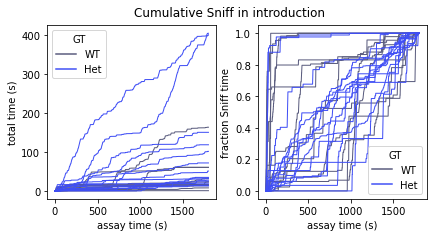

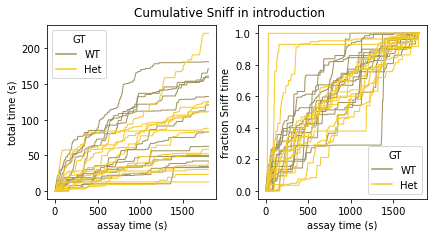

In [6]:
# ----- INTRODUCTION SNIFFS -----
assay = 'introduction'
behavior = 'Sniff'
printy = False
(InSnRaw,InSnBin) = single_behavior_binned_collate_data_and_plot(assay,1800,behavior,nwbpath,printy)

In [ ]:
def make_arbitrary_bins(assaylen,stepsize)
    assaylen = 1800
    nrsteps = int((assaylen)/stepsize)
    bins = np.linspace(0, 1800-stepsize, num=nrsteps)
    return bins

In [ ]:
secbins = make_arbitrary_bins(1800,1)
coll['binbins'] = pd.cut(coll.bins,secbins,labels=secbins)
newdat = coll.groupby(['pair_tag','binbins','GT','sex'])['data'].cumsum().reset_index(name='bincount')

# label the small bins into groups
# group the counts for the larger bins
# do a cumulative or binwise sum
# output those results with metadata

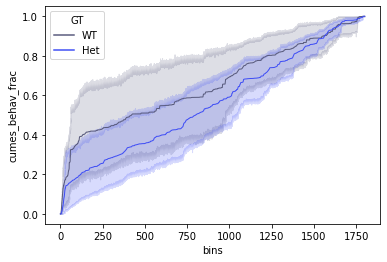

In [62]:
ax0 = sns.lineplot(
        data=InSnBin[InSnBin.sex=='M'],
        x="bins", y="cumes_behav_frac", hue="GT",
        lw=1,palette=mpal,hue_order=ho,
        errorbar = 'se',
    )

In [60]:
mtest = InSnBin[InSnBin.sex=='M'].copy()

In [61]:
mtest.head()

,bins,data,sex,GT,pair_tag,pair,raw_cumes,totals,cumes_behav_frac
0,0.0,0.0,M,Het,Pair17,0,0.0,71.7,0.0
1,0.1,0.0,M,Het,Pair17,0,0.0,71.7,0.0
2,0.2,0.0,M,Het,Pair17,0,0.0,71.7,0.0
3,0.3,0.0,M,Het,Pair17,0,0.0,71.7,0.0
4,0.4,0.0,M,Het,Pair17,0,0.0,71.7,0.0


KeyboardInterrupt: 

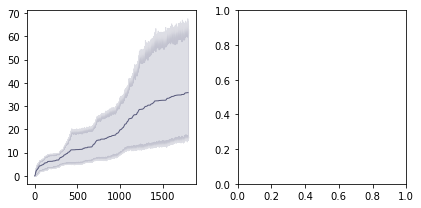

In [55]:
# ----- INTRODUCTION SNIFFS -----
assay = 'introduction'
behavior = 'Sniff'
printy = False
(InSnRaw,InSnBin) = single_behavior_binned_collate_data_and_plot_mean(assay,1800,behavior,nwbpath,printy)

Nov22_Pair15_introductio
Nov22_Pair16_introductio
Nov22_Pair17_introductio
Nov22_Pair18_introductio
Nov22_Pair19_introductio
Nov22_Pair1_introductio
Nov22_Pair21_introductio
Nov22_Pair22_introductio
Nov22_Pair23_introductio
Nov22_Pair24_introductio
Nov22_Pair25_introductio
Nov22_Pair26_introductio
Nov22_Pair27_introductio
Nov22_Pair28_introductio
Nov22_Pair29_introductio
Nov22_Pair2_introductio
Nov22_Pair30_introductio
Nov22_Pair31_introductio
Nov22_Pair32_introductio
Nov22_Pair33_introductio
Nov22_Pair34_introductio
Nov22_Pair35_introductio
Nov22_Pair36_introductio
Nov22_Pair37_introductio
Nov22_Pair38_introductio
Nov22_Pair39_introductio
Nov22_Pair3_introductio
Nov22_Pair40_introductio
Nov22_Pair41_introductio
Nov22_Pair42_introductio
Nov22_Pair43_introductio
Nov22_Pair44_introductio
Nov22_Pair46_introductio
Nov22_Pair47_introductio
Nov22_Pair48_introductio
Nov22_Pair49_introductio
Nov22_Pair4_introductio
Nov22_Pair50_introductio
Nov22_Pair51_introductio
Nov22_Pair52_introductio
Nov2

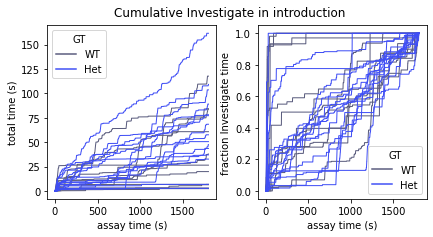

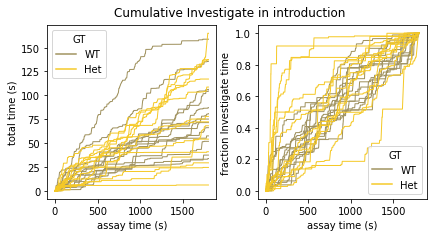

In [7]:
# ----- INTRODUCTION INVESTIGATE -----
assay = 'introduction'
behavior = 'Investigate'
printy = True
(InInRaw,InInBin) = single_behavior_binned_collate_data_and_plot(assay,1800,behavior,nwbpath,printy)

No Huddle
No Huddle


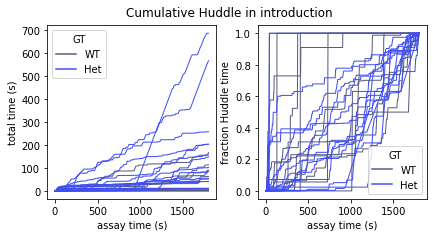

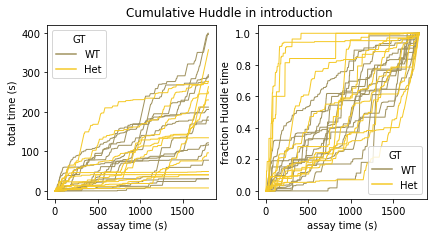

In [8]:
# ----- INTRODUCTION HUDDLE -----
assay = 'introduction'
behavior = 'Huddle'
printy = False
(InHuRaw,InHuBin) = single_behavior_binned_collate_data_and_plot(assay,1800,behavior,nwbpath,printy)

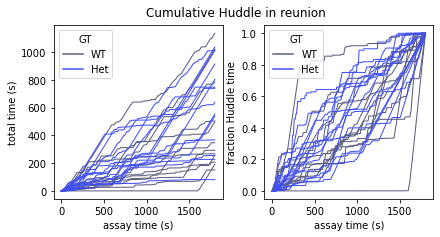

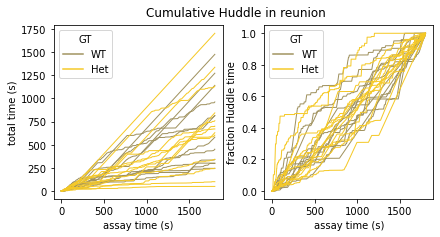

In [53]:
# ----- REUNION HUDDLE -----
assay = 'reunion'
behavior = 'Huddle'
printy = False
(ReHuRaw,ReHuBin) = single_behavior_binned_collate_data_and_plot(assay,1800,behavior,nwbpath,printy)

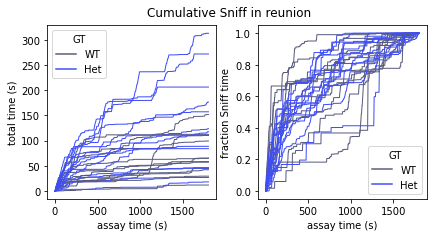

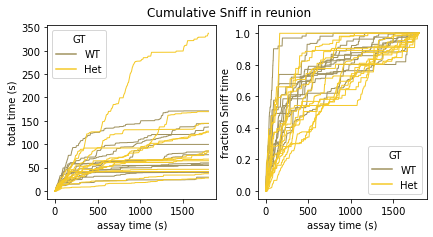

In [54]:
# ----- REUNION SNIFF -----
assay = 'reunion'
behavior = 'Sniff'
printy = False
(ReSnRaw,ReSnBin) = single_behavior_binned_collate_data_and_plot(assay,1800,behavior,nwbpath,printy)

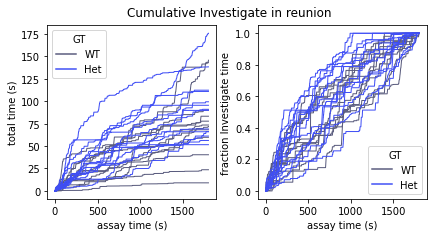

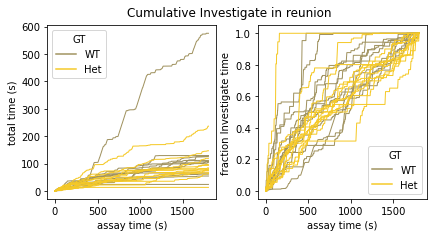

In [55]:
# ----- REUNION INVESTIGATE -----
assay = 'reunion'
behavior = 'Investigate'
printy = False
(ReInRaw,ReInBin) = single_behavior_binned_collate_data_and_plot(assay,1800,behavior,nwbpath,printy)

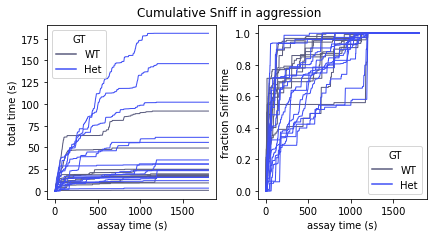

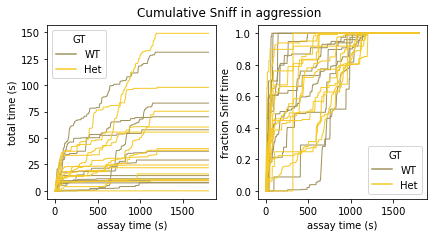

In [56]:
# ----- AGGRESSION SNIFF -----
assay = 'aggression'
behavior = 'Sniff'
printy = False
(AgSnRaw,AgSnBin) = single_behavior_binned_collate_data_and_plot(assay,1800,behavior,nwbpath,printy)

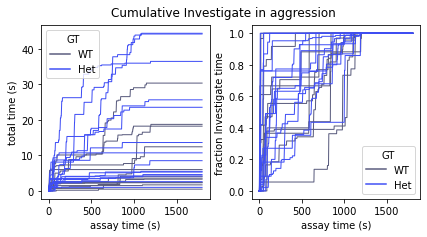

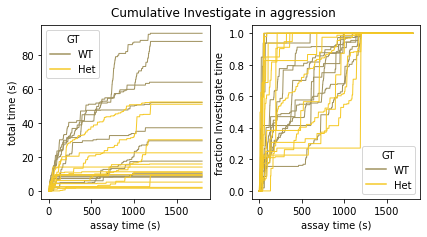

In [57]:
# ----- AGGRESSION INVESTIGATE -----
assay = 'aggression'
behavior = 'Investigate'
printy = False
(AgInRaw,AgInBin) = single_behavior_binned_collate_data_and_plot(assay,1800,behavior,nwbpath,printy)

No Huddle
No Huddle
No Huddle
No Huddle


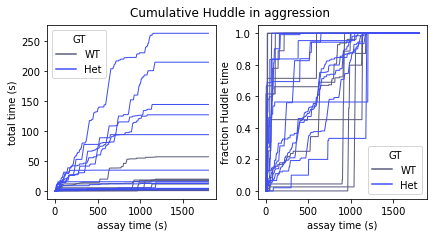

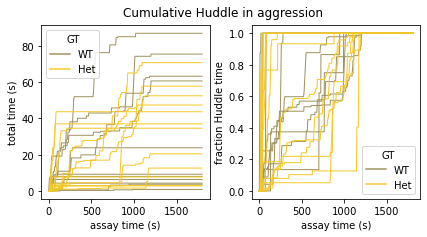

In [58]:
# ----- AGGRESSION HUDDLE -----
assay = 'aggression'
behavior = 'Huddle'
printy = False
(AgHuRaw,AgHuBin) = single_behavior_binned_collate_data_and_plot(assay,1800,behavior,nwbpath,printy)

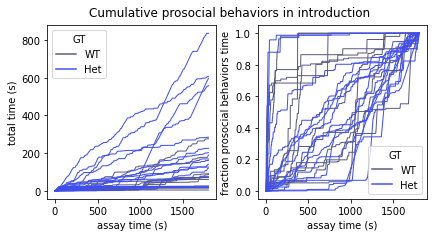

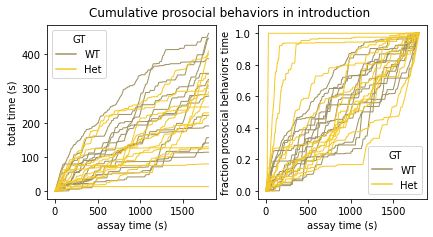

In [47]:
# ----- COMBINE PROSOCIAL BEHAVIOR IN INTRODUCTION -----
behavior = 'prosocial behaviors'
assay = 'introduction'
InPro = pd.concat([InSnRaw,InInRaw,InHuRaw])
InProBins = combined_behavior_bin_and_plot(InPro,1800,behavior,assay)

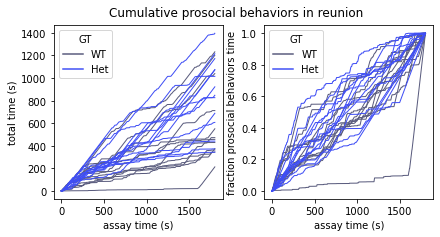

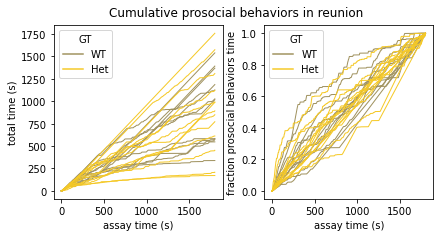

In [48]:
# ----- COMBINE PROSOCIAL BEHAVIOR IN REUNION -----
behavior = 'prosocial behaviors'
assay = 'reunion'
RePro = pd.concat([ReSnRaw,ReInRaw,ReHuRaw])
ReProBins = combined_behavior_bin_and_plot(RePro,1800,behavior,assay)

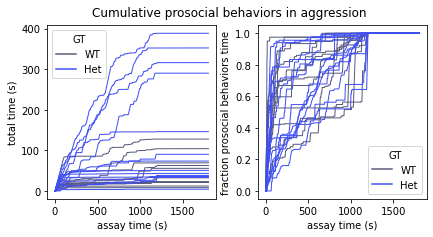

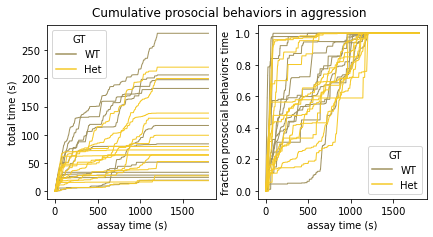

In [62]:
# ----- COMBINE PROSOCIAL BEHAVIOR IN AGGRESSION -----
behavior = 'prosocial behaviors'
assay = 'aggression'
AgPro = pd.concat([AgSnRaw,AgInRaw,AgHuRaw])
AgProBins = combined_behavior_bin_and_plot(AgPro,1800,behavior,assay)

In [28]:
assaylen = 1800
stepsize = 60
nrsteps = int((assaylen)/stepsize)
pdfbins = np.linspace(0, assaylen-stepsize, num=nrsteps)
binlabels = np.linspace(0,len(pdfbins)-1,num=len(pdfbins))[:-1]
# InSnBin['pdf_bin'] = pd.cut(InSnBin['bins'], bins=pdfbins,labels=binlabels)
# InSnBinHist = InSnBin.groupby('pair_tag').pdf_bin.value_counts()
InSnRaw['pdf_bin'] = pd.cut(InSnRaw['start_time'], bins=pdfbins, labels=False)

In [45]:
InSnHist = InSnRaw.groupby(['pair_tag','sex','GT','pdf_bin','pair']).totals.count().reset_index(name='bincount')

In [50]:
InSnHist

,pair_tag,sex,GT,pdf_bin,pair,bincount
0,Pair1,F,Het,0.0,1,3
1,Pair1,F,Het,3.0,1,1
2,Pair1,F,Het,4.0,1,1
3,Pair1,F,Het,6.0,1,2
4,Pair1,F,Het,8.0,1,1
...,...,...,...,...,...,...
811,Pair8,F,WT,24.0,12,2
812,Pair8,F,WT,25.0,12,3
813,Pair8,F,WT,26.0,12,5
814,Pair8,F,WT,27.0,12,1


ValueError: Could not interpret value `pdf_bin` for parameter `x`

<Figure size 864x576 with 0 Axes>

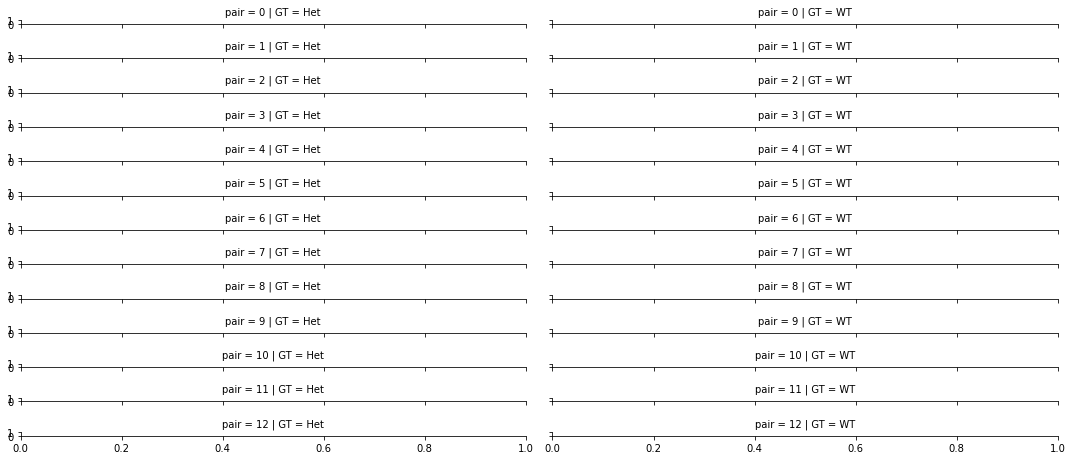

In [51]:
f = plt.figure(figsize=(12, 8))

g = sns.FacetGrid(InSnHist[InSnHist.sex=='F'], row="pair",col='GT', hue="GT", aspect=15, height=.5, palette=fpal)
g.map(sns.lineplot, x='pdf_bin',y='bincount',
      )
# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

<AxesSubplot: xlabel='pdf_bin', ylabel='bincount'>

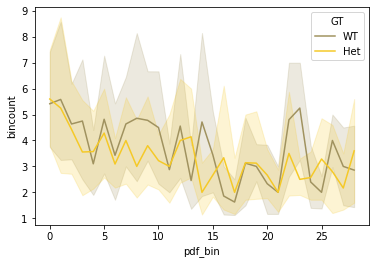

In [52]:
sns.lineplot(data=InSnHist[InSnHist.sex=='F'],x='pdf_bin',y='bincount',hue='GT',palette=fpal,hue_order=['WT','Het'])

<AxesSubplot: xlabel='pdf_bin', ylabel='bincount'>

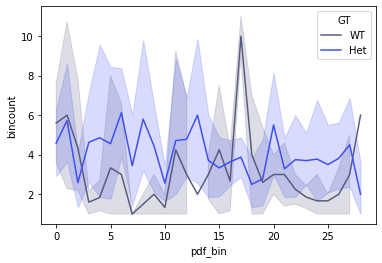

In [61]:
sns.lineplot(data=InSnHist[InSnHist.sex=='M'],x='pdf_bin',y='bincount',hue='GT',palette=mpal,hue_order=['WT','Het'])